# 05.03 Die Hard

Every time I watch a *Die Hard* movie I get the impression that there's almost no women acting.
In other words, I get the impression that everyone in that film is a bunch of blokes hitting each other.
Let's try to check this statistically: collect data about all five *Die Hard* movies and
plot the ratio of actors and actresses in the cast of each movie.

We will use more imports than normally here,
these libraries are present in either the standard library or most scientific distributions of Python.
Notably,these are all present in the anaconda distribution.
Of course, all of them can be installed with `pip`.
A quick outline:

- `time`, `functools` and `collections` are Python standard library utilities for, respectively,
  time related system calls, functional programming with lists, and extra data structures.

- `requests` is a library for processing HTTP calls with a very, very clean API.

- `bs4` (Beautiful Soup 4) is a library to construct a DOM tree (through HTML parsers) and
  traverse that tree with a simple API.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
import time
import functools
import requests
from bs4 import BeautifulSoup
from collections import OrderedDict

We could get the data from a movie database and then work with structured data.
Yet, the main objective of this exercise is to work with rather unstructured and dirty data,
therefore we will take the HTML data from [Wikipedia][wiki] about these movies.
Wikipeida URLs match the title of each movie with underscores instead of spaces.

[wiki]: https://en.wikipedia.org/wiki/Main_Page

In [2]:
movies = ['Die Hard', 'Die Hard 2',
          'Die Hard with a Vengeance', 'Live Free or Die Hard', 'A Good Day to Die Hard']
url_base = 'https://en.wikipedia.org'
urls = dict([(m, url_base + '/wiki/' + m.replace(' ', '_')) for m in movies])
urls

{'A Good Day to Die Hard': 'https://en.wikipedia.org/wiki/A_Good_Day_to_Die_Hard',
 'Die Hard': 'https://en.wikipedia.org/wiki/Die_Hard',
 'Die Hard 2': 'https://en.wikipedia.org/wiki/Die_Hard_2',
 'Die Hard with a Vengeance': 'https://en.wikipedia.org/wiki/Die_Hard_with_a_Vengeance',
 'Live Free or Die Hard': 'https://en.wikipedia.org/wiki/Live_Free_or_Die_Hard'}

OK, we have some data in there about the cast of each movie but this is not the full cast.
That said, we can assume that the actors present on screen most of the time are on the wikipedia page.
Let's write out a handful of assumptions that will help us *scope* the answer to our problem:

- If an actor or actress appears has a lot screen time he/she is more likely
  to appear on the cast list on wikipedia.

- This means that by using the cast for the wikipedia pages consistently
  we can argue that we have a good model of screen time of the Die Hard movies.
  In other words, the most significant the actor is in the movie the most likely
  it is that we can get his name (and wikipedia link) from the cast section.

- The same is valid for missing data.
  The most important is an actor or actress in the movies the most likely
  is that his/her wikipedia page will be complete.

![Die Hard - Wikipedia](da-wikipedia-die-hard-cast.png)

<div style="text-align:right;"><sup>da-wikipedia-die-hard-cast.png</sup></div>

[Section from Wikipedia page for the Die Hard movie][diehard]

[diehard]: https://en.wikipedia.org/wiki/Die_Hard

The cast sections of the wikipedia pages are HTML lists `<ul>`.
We will find those and retrieve all list items which contain a link to a page.
We hope that the link will be to the wikipedia page of the actor/actress
(most of the time it is).

Note: We wait 3 seconds between each call to prevent the wikipedia webservers
from kicking us out as an unpolite crawler.
On the internet, it is polite to wait a moment between calls to not flood a webserver.

In [3]:
def retrieve_cast(url):
    r = requests.get(url)
    print(r.status_code, url)
    time.sleep(3)
    soup = BeautifulSoup(r.text, 'lxml')
    cast = soup.find('span', id='Cast').parent.find_all_next('ul')[0].find_all('li')
    return dict([(li.find('a')['title'], li.find('a')['href']) for li in cast if li.find('a')])


movies_cast = dict([(m, retrieve_cast(urls[m])) for m in movies])
movies_cast

200 https://en.wikipedia.org/wiki/Die_Hard
200 https://en.wikipedia.org/wiki/Die_Hard_2
200 https://en.wikipedia.org/wiki/Die_Hard_with_a_Vengeance
200 https://en.wikipedia.org/wiki/Live_Free_or_Die_Hard
200 https://en.wikipedia.org/wiki/A_Good_Day_to_Die_Hard


{'A Good Day to Die Hard': {'Bruce Willis': '/wiki/Bruce_Willis',
  'Jai Courtney': '/wiki/Jai_Courtney',
  'Mary Elizabeth Winstead': '/wiki/Mary_Elizabeth_Winstead',
  'Sebastian Koch': '/wiki/Sebastian_Koch',
  'Sergei Kolesnikov (actor)': '/wiki/Sergei_Kolesnikov_(actor)',
  'Yuliya Snigir': '/wiki/Yuliya_Snigir'},
 'Die Hard': {'Alan Rickman': '/wiki/Alan_Rickman',
  'Alexander Godunov': '/wiki/Alexander_Godunov',
  'Bonnie Bedelia': '/wiki/Bonnie_Bedelia',
  'Bruce Willis': '/wiki/Bruce_Willis',
  'Clarence Gilyard': '/wiki/Clarence_Gilyard',
  "De'voreaux White": '/wiki/De%27voreaux_White',
  'Hart Bochner': '/wiki/Hart_Bochner',
  'James Shigeta': '/wiki/James_Shigeta',
  'Paul Gleason': '/wiki/Paul_Gleason',
  'Reginald VelJohnson': '/wiki/Reginald_VelJohnson',
  'William Atherton': '/wiki/William_Atherton'},
 'Die Hard 2': {'Art Evans': '/wiki/Art_Evans',
  'Bonnie Bedelia': '/wiki/Bonnie_Bedelia',
  'Bruce Willis': '/wiki/Bruce_Willis',
  'Dennis Franz': '/wiki/Dennis_Franz'

Now we have the links for each actor/actress but again we need to retrieve data from and HTML page.
The *vcard* pane on the right hand side looks promising for data collection:
The pane is organized into a key-value structure,
and it is an HTML table which is easy to transverse.
The data in the pane is still messy but we will worry about that later.

![vcard Pane](da-wikipedia-vcard-pane.png)

<div style="text-align:right;"><sup>da-wikipedia-vcard-pane.png</sup></div>

[Section from Wikipedia page on Bruce Willis][willis]

[willis]: https://en.wikipedia.org/wiki/Bruce_Willis

But there's more.
Looking at the raw HTML we can notice a handful data elements that are not displayed
but which may be useful.  One such element is `bday`,
present in the wikipedia pages of several people,
including some of the actors and actresses we are after.
We should retrieve this data as well.

![Hidden bday](da-wikipedia-hidden-bday.png)

<div style="text-align:right;"><sup>da-wikipedia-hidden-bday.png</sup></div>

Hidden element on Wikipedia page

All that said, we cannot forget that Wikipedia is not a golden source for data.
Data will be dirty, and we will find pages where the *vcard* section is not present,
and it is likely we will not be able to retrieve any data from such pages.
One of our assumptions is that the actors and actresses with most screen time
will have the most complete wikipedia pages,
therefore we should be able to retrieve the most important data.

We also need to think how we are going to structure this data.
We have the cast of each movie but several actors appear in more than one movie.
Let's add to the data about the actor the movies he has played in.
Each time we evaluate the cast of one of the movies we stamp each
actor/actress with the movie title.

Since we are using a polite timer, this will take a while to run.

In [4]:
def retrieve_actor(url):
    full_url = url_base + url
    r = requests.get(full_url)
    print(r.status_code, full_url)
    time.sleep(3)
    soup = BeautifulSoup(r.text, 'lxml')
    data = {}
    bday = soup.find(class_='bday')
    if bday:
        data['bday'] = bday.string
    vcard = soup.find('table', class_='vcard')
    if vcard:
        ths = vcard.find_all('th', scope='row')
        th_rows = [th.text.replace('\xa0', ' ') for th in ths]
        th_data = [th.find_next('td').text.replace('\xa0', ' ') for th in ths]
        data.update(dict(zip(th_rows, th_data)))
    return data


cast = {}
for m in movies_cast:
    for act in movies_cast[m]:
        data = retrieve_actor(movies_cast[m][act])
        data[m] = 1
        if data and act in cast:
            cast[act].update(data)
        elif data:
            cast[act] = data

200 https://en.wikipedia.org/wiki/Bruce_Willis
200 https://en.wikipedia.org/wiki/Alan_Rickman
200 https://en.wikipedia.org/wiki/Alexander_Godunov
200 https://en.wikipedia.org/wiki/Bonnie_Bedelia
200 https://en.wikipedia.org/wiki/Reginald_VelJohnson
200 https://en.wikipedia.org/wiki/Paul_Gleason
200 https://en.wikipedia.org/wiki/De%27voreaux_White
200 https://en.wikipedia.org/wiki/William_Atherton
200 https://en.wikipedia.org/wiki/Clarence_Gilyard
200 https://en.wikipedia.org/wiki/Hart_Bochner
200 https://en.wikipedia.org/wiki/James_Shigeta
200 https://en.wikipedia.org/wiki/Bruce_Willis
200 https://en.wikipedia.org/wiki/Bonnie_Bedelia
200 https://en.wikipedia.org/wiki/Art_Evans
200 https://en.wikipedia.org/wiki/Dennis_Franz
200 https://en.wikipedia.org/wiki/William_Sadler_(actor)
200 https://en.wikipedia.org/wiki/Franco_Nero
200 https://en.wikipedia.org/wiki/Reginald_VelJohnson
200 https://en.wikipedia.org/wiki/William_Atherton
200 https://en.wikipedia.org/wiki/Fred_Thompson
200 https:/

We got the data!

Well, yes, we got *some* data, but that does not yet make it useful data.
First of all we need to try to figure out what kind of values we have.
The *vcard* pane that we parsed was a key-value table,
we should look at what keys we have.

In [5]:
keys = [list(cast[i]) for i in cast]
flat_keys = set(functools.reduce(lambda x, y: x + y, keys))
sorted(flat_keys)

['A Good Day to Die Hard',
 'Alma mater',
 'Associated acts',
 'Birth name',
 'Born',
 'Cause of death',
 'Children',
 'Die Hard',
 'Die Hard 2',
 'Die Hard with a Vengeance',
 'Died',
 'Education',
 'Genres',
 'Height',
 'Home town',
 'Instruments',
 'Known for',
 'Labels',
 'Live Free or Die Hard',
 'Nationality',
 'Notable work',
 'Occupation',
 'Occupation(s)',
 'Other names',
 'Parent(s)',
 'Parents',
 'Partner(s)',
 'Political party',
 'Preceded by',
 'Relatives',
 'Residence',
 'Signature',
 'Spouse(s)',
 'Succeeded by',
 'Website',
 'Years active',
 'bday']

That appears to be good enough.
Some keys are quite clear as to what they represent (e.g. "Occupation"),
others are quite elusive (e.g. "Genres").
One way or another we have a list of keys which we can turn into columns
of a data frame.

We build two data structures:
One a list of the actor and actress names, which we will use as the data frame index.
And the other data structure as a list of values for every key for every actor.

In [6]:
df_name = []
df_columns = {}
for k in flat_keys:
    df_columns[k] = []
for act in cast:
    df_name.append(act)
    for k in df_columns:
        if k in cast[act]:
            df_columns[k].append(cast[act][k])
        else:
            df_columns[k].append(np.nan)
df = pd.DataFrame(df_columns, index=df_name)
df.head()

,A Good Day to Die Hard,Alma mater,Associated acts,Birth name,Born,Cause of death,Children,Die Hard,Die Hard 2,Die Hard with a Vengeance,...,Political party,Preceded by,Relatives,Residence,Signature,Spouse(s),Succeeded by,Website,Years active,bday
Bruce Willis,1.0,Montclair State University,NaN,NaN,Walter Bruce Willis\n(1955-03-19) 19 March 195...,NaN,5,1.0,1.0,1.0,...,NaN,NaN,NaN,"Los Angeles, California, U.S.",NaN,Demi Moore\n(m. 1987; div. 2000)\nEmma Heming\...,NaN,NaN,1979–present,1955-03-19
Alan Rickman,NaN,Royal Academy of Dramatic Art,NaN,NaN,Alan Sidney Patrick Rickman\n(1946-02-21)21 Fe...,Pancreatic cancer,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Rima Horton\n(m. 2012),NaN,NaN,1974–2016,1946-02-21
Alexander Godunov,NaN,NaN,NaN,NaN,Alexander Borisevich Godunov\n(1949-11-28)Nove...,Complications from hepatitis due to chronic al...,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Lyudmila Vlasova\n(m. 1971; div. 1982),NaN,NaN,NaN,1949-11-28
Bonnie Bedelia,NaN,NaN,NaN,NaN,"Bonnie Bedelia Culkin\n(1948-03-25) March 25, ...",NaN,2,1.0,1.0,NaN,...,NaN,NaN,Kit Culkin (brother)\nMacaulay Culkin (nephew)...,NaN,NaN,Ken Luber (m. 1969; div. 1980)\nMichael MacRae...,NaN,NaN,1957–present,1948-03-25
Reginald VelJohnson,NaN,NaN,NaN,NaN,"Reginald Vel Johnson\n(1952-08-16) August 16, ...",NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1979–present,1952-08-16


![John McClane](da-die-hard.svg)

<div style="text-align:right;"><sup>da-die-hard.svg</sup></div>

Now we can operate on this data in `pandas` directly.
We see a lot of `NaN`s, let's figure out how many there are.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, Bruce Willis to Sergei Kolesnikov (actor)
Data columns (total 37 columns):
A Good Day to Die Hard       6 non-null float64
Alma mater                   13 non-null object
Associated acts              1 non-null object
Birth name                   1 non-null object
Born                         43 non-null object
Cause of death               6 non-null object
Children                     16 non-null object
Die Hard                     11 non-null float64
Die Hard 2                   12 non-null float64
Die Hard with a Vengeance    11 non-null float64
Died                         7 non-null object
Education                    3 non-null object
Genres                       1 non-null object
Height                       1 non-null object
Home town                    1 non-null object
Instruments                  2 non-null object
Known for                    4 non-null object
Labels                       2 non-null object
Live Free or

Oh wow!  Most of the columns only have a handful of data, all the remaining rows are `NaN`s.
This is dirty data, therefore we should expect it.
Here we can see that crowd sourced data input (Wikipedia) is often very inconsistent
(e.g. "Parent(s)" vs. "Parents" or "Spouse(s)" vs. "Partner(s)").

What we can do is to select the pieces of data that contain meaningful information
and throw away the rest.  The following keys appear to be usable across most rows.

In [8]:
features = ['Die Hard', 'Die Hard 2', 'Die Hard with a Vengeance',
            'Live Free or Die Hard', 'A Good Day to Die Hard',
            'Alma mater', 'Born', 'Children', 'Nationality',
            'Occupation', 'Occupation(s)', 'Partner(s)', 'Spouse(s)',
            'Years active', 'bday', ]
df = df[features].copy()  # throw old `df` away
df.head()

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday
Bruce Willis,1.0,1.0,1.0,1.0,1.0,Montclair State University,Walter Bruce Willis\n(1955-03-19) 19 March 195...,5,American,"Actor, producer with Cheyenne Enterprises, singer",NaN,NaN,Demi Moore\n(m. 1987; div. 2000)\nEmma Heming\...,1979–present,1955-03-19
Alan Rickman,1.0,NaN,NaN,NaN,NaN,Royal Academy of Dramatic Art,Alan Sidney Patrick Rickman\n(1946-02-21)21 Fe...,NaN,NaN,"Actor, director",NaN,NaN,Rima Horton\n(m. 2012),1974–2016,1946-02-21
Alexander Godunov,1.0,NaN,NaN,NaN,NaN,NaN,Alexander Borisevich Godunov\n(1949-11-28)Nove...,NaN,\n\n\nSoviet (1949–1982; def.)[1]\nUnited Stat...,\n\n\nBallet dancer\nactor\nballet coach\n\n\n,NaN,Jacqueline Bisset (1981–1988),Lyudmila Vlasova\n(m. 1971; div. 1982),NaN,1949-11-28
Bonnie Bedelia,1.0,1.0,NaN,NaN,NaN,NaN,"Bonnie Bedelia Culkin\n(1948-03-25) March 25, ...",2,NaN,Actress,NaN,NaN,Ken Luber (m. 1969; div. 1980)\nMichael MacRae...,1957–present,1948-03-25
Reginald VelJohnson,1.0,1.0,NaN,NaN,NaN,NaN,"Reginald Vel Johnson\n(1952-08-16) August 16, ...",NaN,American,"Actor, comedian",NaN,NaN,NaN,1979–present,1952-08-16


That is easier to look at.
Now we can go back to the question at hand:
Whether there are really that few women in the cast of Die Hard movies.
We do not have the gender of the cast in our data frame but we have their occupation,
and after looking at a handful of the pages we can see that "Actor" often appears.
Also, there are some references to the occupation in the title of the page,
we can try to use that too.

We try to find the strings "actor" or "Actor" in one of the columns
representing the occupation of the person.

In [9]:
actor = (df['Occupation'].str.contains('[Aa]ctor')
         | df['Occupation(s)'].str.contains('[Aa]ctor')
         | df.index.str.contains('[Aa]ctor'))
actor = actor.astype(np.int)
actor

Bruce Willis                 1
Alan Rickman                 1
Alexander Godunov            1
Bonnie Bedelia               0
Reginald VelJohnson          1
Paul Gleason                 1
De'voreaux White             1
William Atherton             1
Clarence Gilyard             1
Hart Bochner                 1
James Shigeta                1
Art Evans                    1
Dennis Franz                 1
William Sadler (actor)       1
Franco Nero                  1
Fred Thompson                0
John Amos                    1
Tom Bower (actor)            1
Sheila McCarthy              0
Jeremy Irons                 1
Samuel L. Jackson            1
Graham Greene (actor)        1
Colleen Camp                 0
Larry Bryggman               1
Anthony Peck                 1
Nick Wyman                   1
Sam Phillips (musician)      0
Stephen Pearlman             1
Kevin Chamberlin             1
Justin Long                  1
Timothy Olyphant             1
Mary Elizabeth Winstead      0
Maggie Q

Looks promising, and looks like there are more ones than zeros,
confirming our initial suspicion.
We have not proved anything yet, though.
Add the indicator we have built to our data frame as a new column,
and let's build the "actress" column next.

In [10]:
df['actor'] = actor
df.head()

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday,actor
Bruce Willis,1.0,1.0,1.0,1.0,1.0,Montclair State University,Walter Bruce Willis\n(1955-03-19) 19 March 195...,5,American,"Actor, producer with Cheyenne Enterprises, singer",NaN,NaN,Demi Moore\n(m. 1987; div. 2000)\nEmma Heming\...,1979–present,1955-03-19,1
Alan Rickman,1.0,NaN,NaN,NaN,NaN,Royal Academy of Dramatic Art,Alan Sidney Patrick Rickman\n(1946-02-21)21 Fe...,NaN,NaN,"Actor, director",NaN,NaN,Rima Horton\n(m. 2012),1974–2016,1946-02-21,1
Alexander Godunov,1.0,NaN,NaN,NaN,NaN,NaN,Alexander Borisevich Godunov\n(1949-11-28)Nove...,NaN,\n\n\nSoviet (1949–1982; def.)[1]\nUnited Stat...,\n\n\nBallet dancer\nactor\nballet coach\n\n\n,NaN,Jacqueline Bisset (1981–1988),Lyudmila Vlasova\n(m. 1971; div. 1982),NaN,1949-11-28,1
Bonnie Bedelia,1.0,1.0,NaN,NaN,NaN,NaN,"Bonnie Bedelia Culkin\n(1948-03-25) March 25, ...",2,NaN,Actress,NaN,NaN,Ken Luber (m. 1969; div. 1980)\nMichael MacRae...,1957–present,1948-03-25,0
Reginald VelJohnson,1.0,1.0,NaN,NaN,NaN,NaN,"Reginald Vel Johnson\n(1952-08-16) August 16, ...",NaN,American,"Actor, comedian",NaN,NaN,NaN,1979–present,1952-08-16,1


This is dirty data, don't make the mistake of assuming that everything that
is not an actor is an actress!  You might get very surprising (and wrong)
results that way.

Let's repeat the procedure of searching the occupation of each person
for the strings "actress" and "Actress".

In [11]:
actress = (df['Occupation'].str.contains('[Aa]ctress')
           | df['Occupation(s)'].str.contains('[Aa]ctress')
           | df.index.str.contains('[Aa]ctress'))
actress = actress.astype(np.int)
df['actress'] = actress
df.head()

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday,actor,actress
Bruce Willis,1.0,1.0,1.0,1.0,1.0,Montclair State University,Walter Bruce Willis\n(1955-03-19) 19 March 195...,5,American,"Actor, producer with Cheyenne Enterprises, singer",NaN,NaN,Demi Moore\n(m. 1987; div. 2000)\nEmma Heming\...,1979–present,1955-03-19,1,0
Alan Rickman,1.0,NaN,NaN,NaN,NaN,Royal Academy of Dramatic Art,Alan Sidney Patrick Rickman\n(1946-02-21)21 Fe...,NaN,NaN,"Actor, director",NaN,NaN,Rima Horton\n(m. 2012),1974–2016,1946-02-21,1,0
Alexander Godunov,1.0,NaN,NaN,NaN,NaN,NaN,Alexander Borisevich Godunov\n(1949-11-28)Nove...,NaN,\n\n\nSoviet (1949–1982; def.)[1]\nUnited Stat...,\n\n\nBallet dancer\nactor\nballet coach\n\n\n,NaN,Jacqueline Bisset (1981–1988),Lyudmila Vlasova\n(m. 1971; div. 1982),NaN,1949-11-28,1,0
Bonnie Bedelia,1.0,1.0,NaN,NaN,NaN,NaN,"Bonnie Bedelia Culkin\n(1948-03-25) March 25, ...",2,NaN,Actress,NaN,NaN,Ken Luber (m. 1969; div. 1980)\nMichael MacRae...,1957–present,1948-03-25,0,1
Reginald VelJohnson,1.0,1.0,NaN,NaN,NaN,NaN,"Reginald Vel Johnson\n(1952-08-16) August 16, ...",NaN,American,"Actor, comedian",NaN,NaN,NaN,1979–present,1952-08-16,1,0


And let's also see who we would consider an actress if we assumed that
everyone who isn't an actor is an actress.

We also save the index value for these rows
(note: there are no rows where actor == 1 and actress == 1,
in a real situation one would need to check for that too but we leave it for brevity).

In [12]:
no_gender = df[(df['actor'] == 0) & (df['actress'] == 0)]
names = no_gender.index.values
no_gender

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday,actor,actress
Fred Thompson,NaN,1.0,NaN,NaN,NaN,Memphis State University (B.A.)\nVanderbilt Un...,Freddie Dalton Thompson\n(1942-08-19)August 19...,5,American,NaN,NaN,NaN,Sarah Knestrick (m. 1959; div. 1985)\nJeri Keh...,NaN,1942-08-19,0,0
Sam Phillips (musician),NaN,NaN,1.0,NaN,NaN,NaN,"(1962-01-28) January 28, 1962 (age 56)\nGlenda...",NaN,NaN,NaN,Singer-songwriter,NaN,NaN,1980–present,1962-01-28,0,0
Yorgo Constantine,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


We could try to guesstimate the gender from the name but that would
probably be using our own bias to make decisions.
And moreover, some names can be very tricky to guess the gender of the person.
Instead we should throw these rows away.

In [13]:
df.drop(names, inplace=True)
df.shape

(42, 17)

We have been looking at this data for a while and we can see other columns that
have useful data.  Let's try to include some more columns.
One good candidate would be to get the age of the people in the data frame.
Let's see if we have the birth day or the "Born" attribute for everyone.

In [14]:
df[df['Born'].isnull() & df['bday'].isnull()]

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday,actor,actress
Tom Bower (actor),NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


Just one person has neither.
And the only reason he is part of our dataset is because of his page title,
i.e. we pretty much have no data about him.
We can go forward without this row.

In [15]:
df.drop('Tom Bower (actor)', inplace=True)
df.shape

(41, 17)

Now let's see if we will need to use the "Born" attribute to build the birth date
of some of the people in our set.  i.e. whether everyone has the "bday" column.

In [16]:
no_bday = df[df['bday'].isnull()]
no_bday

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,Alma mater,Born,Children,Nationality,Occupation,Occupation(s),Partner(s),Spouse(s),Years active,bday,actor,actress
Christina Chang,NaN,NaN,NaN,1.0,NaN,University of Washington,"Taipei, Taiwan",NaN,NaN,Actress/presenter,NaN,NaN,NaN,1998–present,NaN,0,1


OK, one row has no birth date.
But moreover, the "Born" attribute has no date either.
We could just kill off this row too but let's try a trick:
let's assume that she started her career when she was 20 years old,
and guess her age accordingly.
We know the year when she started the career based on the "Years Active" attribute.

In [17]:
byear = no_bday['Years active'].str.extract('(\d+)', expand=False).astype(np.int) - 20
byear

Christina Chang    1978
Name: Years active, dtype: int64

We do not know the actual birth day, let's just say 1st of January.
Which is a low estimate.
The 20 years old as the start of the career was actually a high estimate,
most actors/actresses start before that.
One estimate up and one down should be a good enough shot.

And that's probably enough playing around with this data.
Let's have a look again at how many `NaN`s we have in this new,
cleaned up, data frame.

In [18]:
bday = byear.astype(np.str) + '-01-01'
df.loc[df['bday'].isnull(), 'bday'] = bday
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, Bruce Willis to Sergei Kolesnikov (actor)
Data columns (total 17 columns):
Die Hard                     11 non-null float64
Die Hard 2                   10 non-null float64
Die Hard with a Vengeance    10 non-null float64
Live Free or Die Hard        12 non-null float64
A Good Day to Die Hard       6 non-null float64
Alma mater                   12 non-null object
Born                         41 non-null object
Children                     15 non-null object
Nationality                  14 non-null object
Occupation                   41 non-null object
Occupation(s)                0 non-null object
Partner(s)                   3 non-null object
Spouse(s)                    21 non-null object
Years active                 38 non-null object
bday                         41 non-null object
actor                        41 non-null int64
actress                      41 non-null int64
dtypes: float64(5), int64(2), object(10)
memory usag

Several columns are full of values, notably the columns we have created.
Apart from that we know that that columns with the movie titles contain
`NaN`s where the person did not participate in the movie.
Instead of a `NaN` we should place a zero there.

In [19]:
features = ['Die Hard', 'Die Hard 2', 'Die Hard with a Vengeance',
            'Live Free or Die Hard', 'A Good Day to Die Hard',
            'actor', 'actress', 'bday', ]
df = df[features].copy()
df = df.fillna(0)
df['bday'] = pd.to_datetime(df['bday'])
df.head()

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,actor,actress,bday
Bruce Willis,1.0,1.0,1.0,1.0,1.0,1,0,1955-03-19
Alan Rickman,1.0,0.0,0.0,0.0,0.0,1,0,1946-02-21
Alexander Godunov,1.0,0.0,0.0,0.0,0.0,1,0,1949-11-28
Bonnie Bedelia,1.0,1.0,0.0,0.0,0.0,0,1,1948-03-25
Reginald VelJohnson,1.0,1.0,0.0,0.0,0.0,1,0,1952-08-16


Finally some *clean* data.
Calculating the age now is a simple task: parse the dates and subtract.

In [20]:
df['age'] = (pd.to_datetime('today') - df['bday']).dt.days // 365.25
df

,Die Hard,Die Hard 2,Die Hard with a Vengeance,Live Free or Die Hard,A Good Day to Die Hard,actor,actress,bday,age
Bruce Willis,1.0,1.0,1.0,1.0,1.0,1,0,1955-03-19,63.0
Alan Rickman,1.0,0.0,0.0,0.0,0.0,1,0,1946-02-21,72.0
Alexander Godunov,1.0,0.0,0.0,0.0,0.0,1,0,1949-11-28,68.0
Bonnie Bedelia,1.0,1.0,0.0,0.0,0.0,0,1,1948-03-25,70.0
Reginald VelJohnson,1.0,1.0,0.0,0.0,0.0,1,0,1952-08-16,65.0
Paul Gleason,1.0,0.0,0.0,0.0,0.0,1,0,1939-05-04,79.0
De'voreaux White,1.0,0.0,0.0,0.0,0.0,1,0,1965-08-06,52.0
William Atherton,1.0,1.0,0.0,0.0,0.0,1,0,1947-07-30,70.0
Clarence Gilyard,1.0,0.0,0.0,0.0,0.0,1,0,1955-12-24,62.0
Hart Bochner,1.0,0.0,0.0,0.0,0.0,1,0,1956-10-03,61.0


We will want to do some statistics over the cast of each movie.
It is time to build another data structure:
We keep the full data frame as the total of all movies then divide
(make views) of the data frame based on the columns of each movie.
The cast of the movies may overlap, therefore the same actor/actress
can be in several of these views of the data frame.

In [21]:
dh = OrderedDict({'Total': df})
movies = ['Die Hard', 'Die Hard 2',
          'Die Hard with a Vengeance', 'Live Free or Die Hard', 'A Good Day to Die Hard']
for m in movies:
    dh[m] = df[df[m] == 1]
dh.keys()

odict_keys(['Total', 'Die Hard', 'Die Hard 2', 'Die Hard with a Vengeance', 'Live Free or Die Hard', 'A Good Day to Die Hard'])

Plotting time.
We have the data in the format we'd like to answer the question that brought us here:
Are there many more male cast in Die Hard movies than female?

For each data frame view we plot several bars:
the fatter bars represent the gender ratio (total, actors, actresses),
and the smaller bars are the mean age of each group.
Most of this code is graph prettifying.

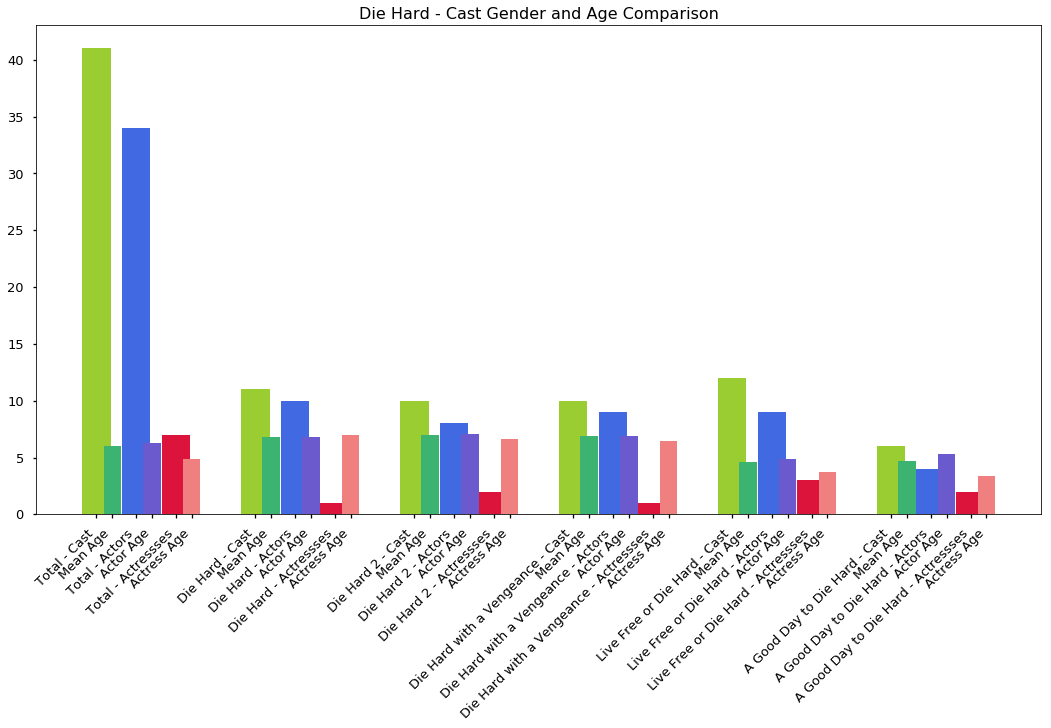

In [22]:
fig, ax = plt.subplots(figsize=(18, 9))
positions = np.array([])
bar_height = []
bar_width = []
labels = []
colors = []
base_position = np.array([1, 1.10, 1.25, 1.35, 1.50, 1.60])
next_position = 0
for m, data in dh.items():
    actor = data[data['actor'] == 1]
    actress = data[data['actress'] == 1]
    positions = np.append(positions, base_position + next_position)
    bar_height += [len(data), data.age.mean() / 10,
                   data.actor.sum(), actor.age.mean() / 10,
                   data.actress.sum(), actress.age.mean() / 10]
    bar_width += [0.18, 0.11, 0.18, 0.11, 0.18, 0.11]
    labels += [m + ' - Cast', 'Mean Age', m + ' - Actors', 'Actor Age', m + ' - Actressses', 'Actress Age']
    colors += ['yellowgreen', 'mediumseagreen', 'royalblue', 'slateblue', 'crimson', 'lightcoral']
    next_position += 1
rects = ax.bar(positions, bar_height, width=bar_width, tick_label=labels, color=colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Die Hard - Cast Gender and Age Comparison', fontsize=16);

## Conclusions

We can answer our question with a **yes**.
The male cast overwhelms the female cast in the Die Hard movies.
In the last movies the ratio has been getting more even but it is still far off.

The male cast keeps with the movies, e.g. Bruce Willis plays in all of them
but the female cast changes.
This likely explains the male mean age going up over time.
Another option is that newer movies casted more younger actresses.
Possibly a combination of both effects.